## Введение (Intro)

#### Что такое Triton

* Triton — это язык и компилятор с открытым исходным кодом от OpenAI, предназначенные для упрощения написания высокоэффективных GPU‑ядер (kernels) для задач машинного обучения / нейронных сетей. 
OpenAI

* Он позиционируется как альтернатива CUDA / низкоуровневому программированию GPU, но при этом с более высоким уровнем абстракции и удобством, особенно для исследователей, которые не хотят заниматься всеми деталями управления памятью и синхронизацией вручную. 
OpenAI
+1

* Triton позволяет писать ядра как обычные (декорированные) функции на Python, а внутри использовать конструкции из triton.language (например, tl.load, tl.store, tl.dot, tl.max и др.). 
OpenAI

#### Модель программирования

* Ядро (kernel) определяется как функция с декоратором @triton.jit, и может быть запущено в сетке (grid) «инстансов» (instances). 
OpenAI

* Вместо модели SIMT (Single Instruction, Multiple Threads), которая характерна для CUDA, Triton оперирует блоками (blocks) — многомерными массивами фиксированного размера (обычно степени двойки). Это упрощает распределение работы и управление памятью внутри блока, избавляя от многих проблем с кооперативной синхронизацией и конфликтами памяти. 
OpenAI
+1

* Внутри каждого блока можно использовать такие примитивы, как tl.arange, tl.load, tl.store, tl.max, tl.sum и др., которые автоматически трансформируются компилятором в оптимизированные операции. 
OpenAI

#### Компилятор / бэкенд

* Triton сначала превращает Python‑функцию в промежуточное представление Triton‑IR (инспирированное LLVM), где блоки являются первоклассными сущностями. 
OpenAI

* Затем производится серия оптимизаций (например, автоматическое выделение и распределение буферов в разделяемую память (shared memory), автоматическое распараллеливание, анализ жизней переменных и др.). 
OpenAI

* После этого Triton‑IR преобразуется в LLVM‑IR, а затем в PTX (для NVIDIA GPU). 
OpenAI

* Triton умеет автоматически размещать данные в разделяемой памяти, минимизировать загрузки из глобальной памяти, делать маски для обработки краёв блоков и т.д. 
OpenAI

#### Примеры использования

* Например, Triton можно использовать для реализации объединённого (fused) softmax – ядро, которое нормализует строки матрицы, не требуя внешних временных буферов и множества промежуточных тензоров. 
OpenAI

* Ещё один пример: матричное умножение (GEMM). При помощи ~25 строк кода на Triton можно получить ядро, близкое по производительности к вручную оптимизированному CUDA-коду. 
OpenAI

* Благодаря возможности «сливать» операции (fusing) — например, сочетать матмуль с активациями или срезами — можно получить ядра, более эффективные, чем последовательное применение библиотек. 
OpenAI

#### Ccылки

* https://triton-lang.org/main/getting-started/tutorials/05-layer-norm.htm

## Установка

#### Установка PyTorch (с поддержкой CUDA 13.0)

In [2]:
# CUDA 13.0 ещё не поддерживается официально PyTorch'ом на 100% — используем CUDA 12.1 сборку (она работает с драйверами 13.0).

#!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

#### Установка Triton

In [3]:
# !pip install -U triton

## Cкалярное умножение массива 

In [ ]:
import triton
import triton.language as tl
import torch

@triton.jit
def scale_kernel(x_ptr, y_ptr, scale, n_elements, BLOCK_SIZE: tl.constexpr):
    pid = tl.program_id(0)
    offsets = pid * BLOCK_SIZE + tl.arange(0, BLOCK_SIZE)
    mask = offsets < n_elements
    x = tl.load(x_ptr + offsets, mask=mask)
    y = x * scale
    tl.store(y_ptr + offsets, y, mask=mask)

# Использование
x = torch.randn(1024, device='cuda')
y = torch.empty_like(x)
scale = 2.0

# Запуск ядра
scale_kernel[(x.numel() // 256,)](x, y, scale, x.numel(), BLOCK_SIZE=256)

Особенности и фичи

* Основан на LLVM и генерирует низкоуровневый код, оптимизированный под конкретный GPU.

* Поддерживает автоматическую векторизацию и memory coalescing.

* Имеет удобную модель параллелизма через program_id, tl.load, tl.store.

## Cкалярное произведение (scale multiplication)

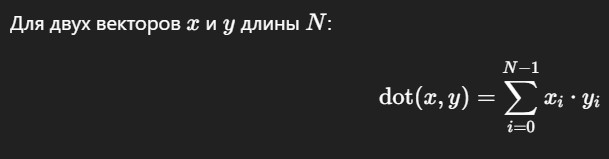

* Мы разбиваем массив на блоки по BLOCK_SIZE (например, 1024).

* Каждый блок считает свой частичный скалярный результат, сохраняется в partial.

* Затем суммируем эти частичные результаты на CPU или с помощью .sum() на GPU.

* Это простой шаблон reduce kernel на Triton.

In [ ]:
import torch
import triton
import triton.language as tl

# Размер векторов
N = 1024 * 1024  # 1 миллион элементов

# Инициализация входов
x = torch.randn(N, device='cuda', dtype=torch.float32)
y = torch.randn(N, device='cuda', dtype=torch.float32)

# Буфер для частичных сумм
partial = torch.empty((triton.cdiv(N, 1024),), device='cuda', dtype=torch.float32)

# Triton ядро
@triton.jit
def dot_kernel(x_ptr, y_ptr, output_ptr, n_elements, BLOCK_SIZE: tl.constexpr):
    pid = tl.program_id(0)  # Один блок на каждый "кусок" данных
    block_start = pid * BLOCK_SIZE
    offsets = block_start + tl.arange(0, BLOCK_SIZE)
    mask = offsets < n_elements

    x_vals = tl.load(x_ptr + offsets, mask=mask)
    y_vals = tl.load(y_ptr + offsets, mask=mask)
    prod = x_vals * y_vals

    acc = tl.sum(prod, axis=0)
    tl.store(output_ptr + pid, acc)

'''------------------------------```
    Сравнение Triton vs Pytorch
```------------------------------'''

import time

BLOCK_SIZE = 1024
grid = lambda meta: (triton.cdiv(N, meta['BLOCK_SIZE']),)

# Triton
start = time.time()
dot_kernel[grid](x, y, partial, N, BLOCK_SIZE=BLOCK_SIZE)
torch.cuda.synchronize()
triton_result = partial.sum()
triton_time = time.time() - start

# PyTorch
start = time.time()
torch_result = torch.dot(x, y)
torch.cuda.synchronize()
torch_time = time.time() - start

# === Сравнение ===
print(f"Triton result:     {triton_result.item():.6f}")
print(f"PyTorch result:    {torch_result.item():.6f}")
print(f"Max error:         {abs(triton_result - torch_result):.6e}")
print(f"Triton time:       {triton_time:.6f} seconds")
print(f"PyTorch time:      {torch_time:.6f} seconds")

## Векторное умножение (element-wise multiplication)

У нас есть два вектора x и y, и мы хотим вычислить:
```
z = x * y
```


In [ ]:
import torch
import triton
import triton.language as tl

# Размер данных
N = 1024 * 1024

# Входные данные
x = torch.randn(N, device='cuda')
y = torch.randn(N, device='cuda')
z = torch.empty_like(x)

# Triton-ядро
@triton.jit
def vector_mul_kernel(x_ptr, y_ptr, z_ptr, n_elements, BLOCK_SIZE: tl.constexpr):
    pid = tl.program_id(axis=0)
    block_start = pid * BLOCK_SIZE
    offsets = block_start + tl.arange(0, BLOCK_SIZE)
    
    mask = offsets < n_elements

    x_val = tl.load(x_ptr + offsets, mask=mask)
    y_val = tl.load(y_ptr + offsets, mask=mask)
    tl.store(z_ptr + offsets, x_val * y_val, mask=mask)

# Запуск ядра
BLOCK_SIZE = 1024
grid = lambda meta: (triton.cdiv(N, meta['BLOCK_SIZE']),)

vector_mul_kernel[grid](x, y, z, N, BLOCK_SIZE=BLOCK_SIZE)

'''------------------------------```
    Сравнение Triton vs Pytorch
```------------------------------'''

import time

# Triton
z_triton = torch.empty_like(x)
start = time.time()
vector_mul_kernel[grid](x, y, z_triton, N, BLOCK_SIZE=BLOCK_SIZE)
torch.cuda.synchronize()
print("Triton time:", time.time() - start)

# PyTorch
start = time.time()
z_torch = x * y
torch.cuda.synchronize()
print("PyTorch time:", time.time() - start)

# Проверка на точность
print("Max error:", torch.max(torch.abs(z_triton - z_torch)))

## Softmax

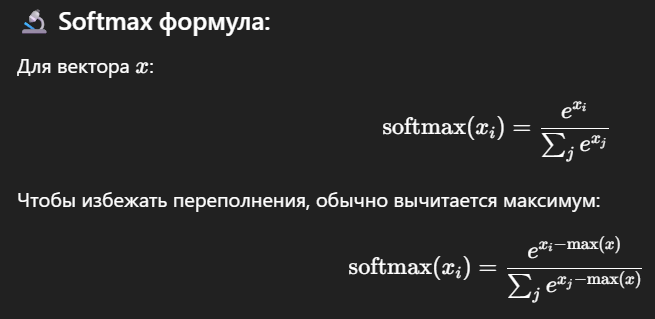

In [1]:
import triton
import triton.language as tl
import torch

@triton.jit
def softmax_kernel(
    input_ptr, output_ptr, n_cols,
    BLOCK_SIZE: tl.constexpr,
):
    row = tl.program_id(0)
    offsets = row * n_cols + tl.arange(0, BLOCK_SIZE)
    mask = tl.arange(0, BLOCK_SIZE) < n_cols

    # Считываем строку
    x = tl.load(input_ptr + offsets, mask=mask)

    # Вычисляем softmax (стабильный)
    x_max = tl.max(x, axis=0)
    x = x - x_max
    num = tl.exp(x)
    denom = tl.sum(num, axis=0)
    y = num / denom

    # Записываем результат
    tl.store(output_ptr + offsets, y, mask=mask)

# Тест
n_rows, n_cols = 1024, 128
x = torch.randn((n_rows, n_cols), device='cuda')
y = torch.empty_like(x)

# Запуск Triton softmax
softmax_kernel[(n_rows,)](
    x, y, n_cols,
    BLOCK_SIZE=n_cols,
)

'''------------------------------```
    Сравнение Triton vs Pytorch
```------------------------------'''
import time

# Triton
start = time.time()
softmax_kernel[(n_rows,)](x, y, n_cols, BLOCK_SIZE=n_cols)
torch.cuda.synchronize()
print("Triton softmax time:", time.time() - start)

# PyTorch
start = time.time()
y_ref = torch.nn.functional.softmax(x, dim=1)
torch.cuda.synchronize()
print("PyTorch softmax time:", time.time() - start)

# Проверка точности
print("Max error:", (y - y_ref).abs().max().item())

PermissionError: [WinError 5] Access is denied